# Machine Learning Model Development:Extreme Gradient Boosting

![XGBoost](./Images/XGBoost.PNG)

The machine learning XGBoost algorithm is an optimized distributed gradient boosting model designed for efficient and scalable training. 
It is an ensemble learning method that combines the predictions of multiple weak models to improve model prediction skill.
XGBoost has become a very popular ML algorihtm due to the ability to handle large datasets and deliver high predictive performance for both classification and regression modeling goals.
Additional XGBoost algorithm information can be found [here](https://www.geeksforgeeks.org/xgboost/).

There are many blogs and online tutorials that can assist in ML model development.
For this example, we borrowed the workflow from [Machine Learning Mastery](https://machinelearningmastery.com/xgboost-for-regression/).

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import joblib
import hydroeval as he
from pickle import dump
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# check xgboost version
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score



In [30]:
#read in the dataframe
Training_DF = pd.read_csv('./Data/Training_DF_RJ.csv')

#remove first column
Training_DF.pop('Unnamed: 0')

Training_DF

,temperature_F,precipitation_in,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,DOY,flow_cfs
0,30.506,0.260400,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,1,1.607283
1,30.866,0.128416,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,2,1.636875
2,30.218,0.040376,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,3,1.580729
3,30.398,0.011112,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,4,1.580000
4,28.436,0.008684,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,5,1.582188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,38.066,0.052752,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,360,6.631250
3281,35.600,0.517000,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,361,7.216562
3282,33.206,1.418972,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,362,8.534375
3283,25.736,0.122988,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,363,7.092917


## Data preprocessing
During the first pass of model training, we got some errors due to inf and/or nan.
Lets investigate

In [31]:
Training_DF[Training_DF.isna().any(axis=1)]

,temperature_F,precipitation_in,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,DOY,flow_cfs
1046,37.47200,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,316,NaN
1047,33.42207,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,317,NaN
1048,30.34400,0.000300,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,318,NaN
1049,30.68600,0.000400,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,319,NaN
1050,31.15400,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,320,NaN
1051,32.90000,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,321,NaN
1052,29.58800,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,322,NaN
1053,28.94000,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,323,NaN
1054,32.23400,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,324,NaN
1055,33.78200,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,325,NaN


## Looks like we had some bad streamflow data, lets remove it!


In [32]:
#Use dropna() function
Training_DF.dropna(inplace = True)

#Check to make sure that there are no nan values
Training_DF[Training_DF.isna().any(axis=1)]

,temperature_F,precipitation_in,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,DOY,flow_cfs


## Final Data Preparation for ML model training
The DataFrame looks good, now lets split the data into a training and testing datasets, and then create a scaler for the data. 
XGBoost does not require this but others do and it is a good housekeeping step.


In [33]:
#Split the data into features and target
y = Training_DF['flow_cfs']

#remove target from features
Training_DF.pop('flow_cfs')

X = Training_DF

In [34]:
'''The DataFrame looks good, now lets scale the data. 
XGBoost does not require this but others do and it is a good housekeeping step.
'''

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
y_train = pd.DataFrame(y_train)
# define scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
# fit scaler on the training dataset
scaler_x.fit(X_train)
scaler_y.fit(y_train)
# transform the training dataset
X_train_scaled = scaler_x.transform(X_train)
y_train_scaled = scaler_y.transform(y_train)

# save the scaler, changed name
dump(scaler_x, open('./Model/XGBoost/scaler_x_RJ.pkl', 'wb'))
dump(scaler_y, open('./Model/XGBoost/scaler_y_RJ.pkl', 'wb'))

## Train an XGBoost Model

The XGBoost library has its own custom API and we we can use the method via the scikit-learn wrapper classes: XGBRegressor().
The XGBRegressor() class will allow us to use the full suite of tools from the [scikit-learn machine learning library](https://scikit-learn.org/stable/modules/ensemble.html) to prepare data and evaluate models.

We can define XGBoost regression model by creating an instance of the XGBRegressor class, see below.

Hyper-parameters are parameters that are not directly learnt within estimators. 
In scikit-learn they are passed as arguments to the constructor of the estimator classes. 
An XGBoost model takes in hyperparameter values to configure the model, these help "tune" the model to gain predictive skill.

The most commonly configured hyperparameters are the following:

* n_estimators: The number of trees in the ensemble, often increased until no further no further prediction skill improvements.
* max_depth: The maximum depth of each tree with values often between 1 and 10.
* eta: The learning rate functions to weight each model, with a recommendation to set to small values such as 0.3, 0.1, 0.01, or smaller.
* subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, with 1.0 using all samples.
* colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, use 1.0 to use all features.

Good hyperparameter values can be found by trial and error for a given dataset, or systematic experimentation such as using a grid search across a range of values. 
We will explore a grid search in a later step.

The model uses randomness in its construction, meaning that each time the algorithm is run on the same data that it can produce a slightly different model.

When developing machine learning models that have a stochastic learning algorithm, it is good practice to evaluate the model through averaging model performance across multiple runs or repeats of cross-validation. 

We will use a test harness of repeated stratified 10-fold cross-validation with three repeats and evaluate the model using the best practice of repeated k-fold cross-validation with 3 repeats and 10 folds within the training dataset.
This step will use the RepeatedKFold class to configure the evaluation procedure and calling the cross_val_score() to evaluate the model using the procedure and collect the scores.

Model performance will be evaluated using mean squared error (MAE).
Note, MAE is made negative in the scikit-learn library so that it can be maximized.

In [35]:
# create an xgboost regression model
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(model, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

#fit the model
print('Fitting the model')
model.fit(X_train_scaled, y_train_scaled)

#Save the model, adjust this to match changing models
dump(model, open('./Model/XGBoost/Model_RJ.dat', "wb")) 

# Caculate model performance and force scores to be positive
print('Mean MAE: %.3f (%.3f)' % (abs(scores.mean()), scores.std()) )

Fitting the model
Mean MAE: 0.023 (0.002)


## Model Evaluation

We have MAE for the cross validaiton data but we want to A) see where the model predicts well and poor and B) evaluate the model on the unseen testing data. 

The first step is to make predictions on the unseen data and connect predictions, observations, and the features into a Pandas DataFrame.

In [36]:
#scale the predictor inputs
#load the scalers
scaler_x = pickle.load(open('./Model/XGBoost/scaler_x_RJ.pkl', 'rb'))
scaler_y = pickle.load(open('./Model/XGBoost/scaler_y_RJ.pkl', 'rb'))

#apply the scaler to the X_testing data
X_test_scaled = scaler_x.transform(X_test)

#Load the model
model = pickle.load(open('./Model/XGBoost/Model_RJ.dat', "rb"))

# make a prediction
y_pred = model.predict(X_test_scaled)
    
#scale the predictions back to streamflow in cfs and convert to pandas DataFrame
y_pred = pd.DataFrame(scaler_y.inverse_transform(pd.DataFrame(y_pred)),columns = ['flow_cfs_pred'])
y_test = pd.DataFrame(y_test, columns = ['flow_cfs'])

#Combine X_test, y_pred, and y_test DataFrames to evaluate the performance of the model
#reset indexes
DFs = [y_pred, y_test, X_test]
for df in DFs:
    df.reset_index(drop = True, inplace = True)
    
#merge
Eval_DF = pd.concat(DFs, axis=1)

Eval_DF

,flow_cfs_pred,flow_cfs,temperature_F,precipitation_in,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,DOY
0,52.759178,31.354166,54.30207,0.000000,40.759670,-111.564091,64.60,7420.0,65.4,13.1,3.65000,2.63,36.3,26.2,114
1,7.605543,7.654792,50.03600,0.000000,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,311
2,1.480407,1.389896,26.11400,0.019536,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,66
3,12.584676,10.223750,66.32600,0.013032,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,170
4,13.086857,23.468750,66.95600,0.005840,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,3.146697,1.463750,53.07800,0.000432,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,87
1067,0.963233,1.125417,81.46400,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,197
1068,10.373218,8.642396,79.93407,0.000000,40.759670,-111.564091,64.60,7420.0,65.4,13.1,3.65000,2.63,36.3,26.2,252
1069,16.871632,19.536459,73.76007,0.000000,40.759670,-111.564091,64.60,7420.0,65.4,13.1,3.65000,2.63,36.3,26.2,174


### Now we can put the data through some metrics and plot to investigate performance

Let's make a plotting function so we can investigate and compare future model performance.

In [37]:
#we can make a plotting function that takes in a list of up to 4 model predictions

def Model_Evaluation_Plots(DF, predictions):

# Subplots.
    fig, ax = plt.subplots(1,1, figsize=(8, 7))
    fig.patch.set_facecolor('white')

    #set min/max for y-axis of the predictions/observations
    ymin = min(DF['flow_cfs'])*1.1
    ymax = max(DF['flow_cfs'])*1.1
    
    #add color options
    colors = ['blue', 'orange', 'red','green']


    # Add predictions to plot
    for pred in np.arange(0, len(predictions),1):
        ax.scatter(DF['flow_cfs'], DF[predictions[pred]],
                   c=colors[pred], alpha=0.35, label=predictions[pred])

     # Add some parameters.
    ax.set_title('Streamflow Predictions', fontsize=16)
    ax.set_xlabel('Observations (cfs)', fontsize=14)
    ax.set_ylabel('Predictions (cfs)', fontsize=14,)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(ymin, ymax)
    ax.legend(fontsize=14, loc='upper right')
    
    #Add a 1:1 prediction:observation plot
    ax.plot((0,ymax),(0,ymax), linestyle = '--', color  = 'red')

    plt.show()
    

#Define some key model performance metics: RMSE, PBias, MAE, MAPE
def RMSE(DF, predictions):
    for pred in np.arange(0, len(predictions),1):
        rmse = mean_squared_error(DF['flow_cfs'], DF[predictions[pred]], squared=False)
        print('RMSE for ', predictions[pred], ' is ', rmse, ' cfs')

def MAPE(DF, predictions):
    for pred in np.arange(0, len(predictions),1):
        mape = round(mean_absolute_percentage_error(DF['flow_cfs'], DF[predictions[pred]])*100, 2)
        print('Mean Absolute Percentage Error for ', predictions[pred], ' is ', mape, '%')
        
def PBias(DF, predictions):
    for pred in np.arange(0, len(predictions),1):
        pbias = he.evaluator(he.pbias,  DF[predictions[pred]], DF['flow_cfs'])
        pbias = round(pbias[0],2)
        print('Percentage Bias for ', predictions[pred], ' is ', pbias, '%')
        
def KGE(DF, predictions):
    for pred in np.arange(0, len(predictions),1):
        kge, r, alpha, beta = he.evaluator(he.kge,  DF[predictions[pred]], DF['flow_cfs'])
        kge = round(kge[0],2)
        print('Kling-Glutz Efficiency for ', predictions[pred], ' is ', kge)
        

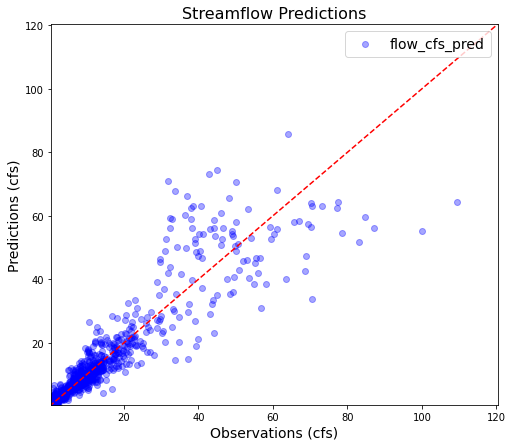

RMSE for  flow_cfs_pred  is  6.100468925688844  cfs
Mean Absolute Percentage Error for  flow_cfs_pred  is  33.58 %
Percentage Bias for  flow_cfs_pred  is  -0.58 %
Kling-Glutz Efficiency for  flow_cfs_pred  is  0.91


In [38]:
prediction_columns = ['flow_cfs_pred']

#plot the predictions
Model_Evaluation_Plots(Eval_DF, prediction_columns)

#Get RMSE from the model
RMSE(Eval_DF, prediction_columns)

#Get Mean Absolute Percentage Error from the model
MAPE(Eval_DF, prediction_columns)

#Get Percent Bias from the model
PBias(Eval_DF, prediction_columns)

#Get Kling-Gutz Efficiency from the model
KGE(Eval_DF, prediction_columns)


## Lets see if we can optimize model prediction skill
The grid search provided by GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter. 



In [39]:
#make some functions to easily change/evaluate our model(s)
def XGBoost_GridSearch(hyperparameters, modelname):
    path = './Model/'+modelname+'_params.pkl'
    # create an xgboost regression model
    xgb1 = XGBRegressor()

    #set up the GridSearchCV function
    xgb_grid = GridSearchCV(xgb1,
                            hyperparameters,
                            cv = 3,
                            n_jobs = -1,
                            verbose=3
                           )

    #Run the GridSearch fit functtion
    xgb_grid.fit(X_train_scaled, y_train_scaled)

    print('The best hyperparameter three-fold cross validation score is: ')
    print(xgb_grid.best_score_)

    print(' ')
    print('The optimal hyper-parameters are: ')
    print(xgb_grid.best_params_)
    
    #save the model features
    joblib.dump(xgb_grid, path)



In [40]:
#make some ranges of hyperparamter values of interest
hyperparameters = {
    'max_depth': range (2, 11, 3),
    'n_estimators': range(100, 2100, 500),
    'eta': [0.1, 0.01, 0.05]
}

#run he GridSearchCV function
XGBoost_GridSearch(hyperparameters, 'XGBoost/XGBoost_RJ')



Fitting 3 folds for each of 36 candidates, totalling 108 fits
The best hyperparameter three-fold cross validation score is: 
0.87066658192416
 
The optimal hyper-parameters are: 
{'eta': 0.01, 'max_depth': 5, 'n_estimators': 600}


In [41]:
#load parameters and train model on CV methods as the original model
parameters = joblib.load('./Model/XGBoost/XGBoost_RJ_params.pkl')
eta = parameters.best_params_['eta']
max_depth =parameters.best_params_['max_depth']
n_estimators = parameters.best_params_['n_estimators']

# create an xgboost regression model
model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=eta, subsample=0.7, colsample_bytree=0.8)


# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(model, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)


#fit the model
print('Fitting the model')
model.fit(X_train_scaled, y_train_scaled)

#Save the model, adjust this to match changing models
dump(model, open('./Model/XGBoost/Model_HyperParam_RJ.dat', "wb")) 

# Caculate model performance and force scores to be positive
print('Mean MAE: %.3f (%.3f)' % (abs(scores.mean()), scores.std()) )

Fitting the model
Mean MAE: 0.022 (0.002)


## Make predictions on unseen testing data with "optimized" model


In [42]:
#scale the predictor inputs
#load the scalers
scaler_x = pickle.load(open('./Model/XGBoost/scaler_x_RJ.pkl', 'rb'))
scaler_y = pickle.load(open('./Model/XGBoost/scaler_y_RJ.pkl', 'rb'))

#apply the scaler to the X_testing data
X_test_scaled = scaler_x.transform(X_test)

#Load the model, remember to change it ot the correction one!
model = pickle.load(open('./Model/XGBoost/Model_HyperParam_RJ.dat', "rb"))

# make a prediction
y_pred_Hyp = model.predict(X_test_scaled)
    
#scale the predictions back to streamflow in cfs and convert to pandas DataFrame
y_pred_Hyp = pd.DataFrame(scaler_y.inverse_transform(pd.DataFrame(y_pred_Hyp)),columns = ['flow_cfs_Hyp_pred'])


#Combine X_test, y_pred, and y_test DataFrames to evaluate the performance of the model
#reset indexes
DFs = [y_pred_Hyp, y_pred, y_test, X_test]
for df in DFs:
    df.reset_index(drop = True, inplace = True)
    
#merge
Eval_DF = pd.concat(DFs, axis=1)

Eval_DF

,flow_cfs_Hyp_pred,flow_cfs_pred,flow_cfs,temperature_F,precipitation_in,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,DOY
0,52.731083,52.759178,31.354166,54.30207,0.000000,40.759670,-111.564091,64.60,7420.0,65.4,13.1,3.65000,2.63,36.3,26.2,114
1,7.438922,7.605543,7.654792,50.03600,0.000000,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,311
2,1.645185,1.480407,1.389896,26.11400,0.019536,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,66
3,12.624098,12.584676,10.223750,66.32600,0.013032,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,170
4,16.036222,13.086857,23.468750,66.95600,0.005840,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,3.566906,3.146697,1.463750,53.07800,0.000432,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,87
1067,1.410374,0.963233,1.125417,81.46400,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,197
1068,10.082862,10.373218,8.642396,79.93407,0.000000,40.759670,-111.564091,64.60,7420.0,65.4,13.1,3.65000,2.63,36.3,26.2,252
1069,16.759605,16.871632,19.536459,73.76007,0.000000,40.759670,-111.564091,64.60,7420.0,65.4,13.1,3.65000,2.63,36.3,26.2,174


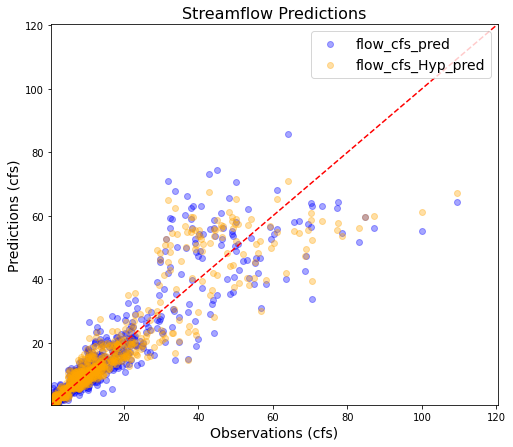

RMSE for  flow_cfs_pred  is  6.100468925688844  cfs
RMSE for  flow_cfs_Hyp_pred  is  5.569283069280557  cfs
Mean Absolute Percentage Error for  flow_cfs_pred  is  33.58 %
Mean Absolute Percentage Error for  flow_cfs_Hyp_pred  is  29.37 %
Percentage Bias for  flow_cfs_pred  is  -0.58 %
Percentage Bias for  flow_cfs_Hyp_pred  is  -1.51 %
Kling-Glutz Efficiency for  flow_cfs_pred  is  0.91
Kling-Glutz Efficiency for  flow_cfs_Hyp_pred  is  0.92


In [28]:
#Evaluate model performance of the different models
prediction_columns = ['flow_cfs_pred', 'flow_cfs_Hyp_pred']

#plot the predictions
Model_Evaluation_Plots(Eval_DF, prediction_columns)

#Get RMSE from the model
RMSE(Eval_DF, prediction_columns)

#Get Mean Absolute Percentage Error from the model
MAPE(Eval_DF, prediction_columns)

#Get Percent Bias from the model
PBias(Eval_DF, prediction_columns)

#Get Kling-Gutz Efficiency from the model
KGE(Eval_DF, prediction_columns)

# Exercise


**If you have not yet done so, make a copy of this Notebook with your initials_GEE_Workshop_CH2, e.g., RJ_GEE_Workshop_CH2. 
Save to the Exercises folder.**

## Lets see how the model performs in an operational setting in the final chapter

Go back to the [Chapter 3](../GEE_Workshop_CH3.ipynb)

